## Урок 4. Generative adversarial networks

## Домашнее задание
1. Обучить генератор создавать точки, которые будут лежать на графике функции 
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

**Примечание:** 

При решении возникла пара вопросов. Поэтому, пару моментов подсмотрел вот здесь - https://proglib.io/p/generativno-sostyazatelnaya-neyroset-vasha-pervaya-gan-model-na-pytorch-2020-08-11

## 0. Подготовка
Подключаем нужные модули и библиотеки

In [1]:
import os
import numpy as np
import math
import pandas as pd

from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

import torchvision.transforms.functional as TF

Определим нужное нам устройство:

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
n_epochs = 150  # количество эпох
lr = 0.0001  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

latent_dim = 2  # Размерность случайного вектора, который подается на вход генератору

sample_interval = 200  # количество итераций для отображения процесса обучения

batch_size = 16  # размер батча

func_shape = 2 #  Т.к. мы строим двумерный график, то генератор должен выдавать 
               # две координаты X и Y.

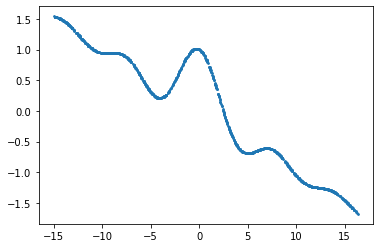

In [4]:
train_data_length = 1024

train_data = torch.zeros((train_data_length, 2))
train_labels = torch.zeros(train_data_length)

train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)*5-15
train_data[:, 1] = torch.sin(train_data[:, 0])/train_data[:, 0]-(train_data[:, 0]/10)

train_ds = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

plt.scatter(train_data[:,0],train_data[:,1],s=3)
plt.show()

In [5]:
real_data = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

### 2. Создание модели

#### 2.1 Генератор

Генератор G предназначен для отображения вектора скрытого пространства (z) в пространство данных. Наши данные представляют собой точки лежащие на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. Т.о. из скрытого простанства нам необходимо получить координаты x и y на плоскости.которые бы лежали на этой кривой 

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]  # Если мы создаем последовательность слоев - то мы задаем их
                                                     # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])  # Эта строчка означает тоже самое что и
                                                         # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128),  # Звездочка означает unpacking списка
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, func_shape),
            # nn.Tanh()
        )

    def forward(self, z):
        func_out = self.model(z)
        return func_out

**Небольшое отступление**
Создание своих слоев. Если все правильно оформить, то созданный кастомный слой можно будет использовать внутри PyTorch как обычный слой.

In [7]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) # Обьявляем веса как параметры слоя

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данные 
        # на транспонированные веса и добавить смещение
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

In [8]:
layer = CustomLinearLayer(1, 2)
layer.weights, layer.bias

(Parameter containing:
 tensor([[0.0031],
         [0.0017]], requires_grad=True),
 Parameter containing:
 tensor([0.0008, 0.0006], requires_grad=True))

nn.init.uniform_ Позволяет нам задать значения с помощью нормального распределения

#### 2.2 Дискриминатор

Как уже упоминалось, дискриминатор D представляет собой сеть двоичной классификации, который принимает координаты точек на плоскости в качестве входных данных и выводит скалярную вероятность того, что точки принадлежат к кривой описываемой уравнением $y = \frac{sin(x)}{x} - \frac{x}{10}$.

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(func_shape, 512),
            # nn.BatchNorm1d(512),
            # nn.Dropout(0.3),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            # nn.Dropout(0.3),
            # nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, func):
        validity = self.model(func)
        return validity

# 3. Обучение

Инициализация:

In [10]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [ ]:
d_loss_history = []
g_loss_history = []

Процесс обучения:

[Epoch 296/300] [Batch 56/64]|[D loss: 0.6932711601257324] [G loss: 0.6928741335868835]


<Figure size 432x288 with 0 Axes>

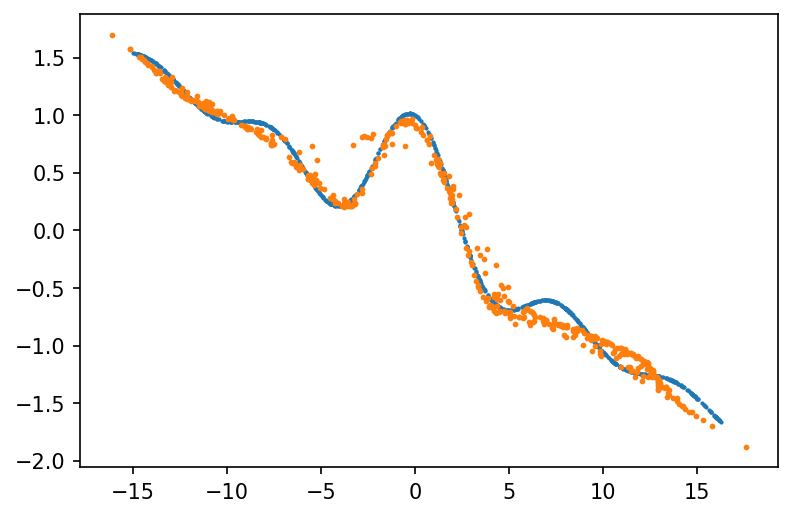

<Figure size 432x288 with 0 Axes>

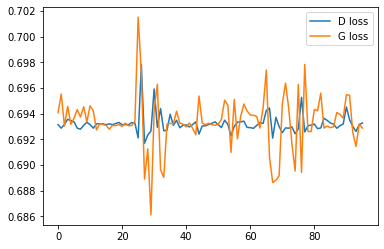

In [ ]:
import matplotlib.patches as mpatches


red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

for epoch in range(n_epochs):
    for i, (sample, __ ) in enumerate(real_data):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device) # Заполним массив 1-ми
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device) # Заплним массив нулями. 

        real_sample = sample.type(torch.FloatTensor).to(device)

        # Генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_samples = generator(z)
        
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_sample)
        # print(real_pred,valid)
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_samples)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_samples = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_samples)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                # sample_image(gen_imgs)
                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(real_data)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 

                z = torch.FloatTensor(np.random.normal(0, 1, (500, latent_dim))).to(device)
                generated_samples = generator(z)

                generated_samples = generated_samples.cpu().detach()
                plt.figure(dpi=150)
                plt.scatter(train_data[:,0],train_data[:,1],s=1)
                plt.scatter(generated_samples[:,0], generated_samples[:,1], s=3)
                plt.show()  
                
                display.display(plt.gcf())  
                
                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()

                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.array(d_loss_history), label='D loss')
                plt.plot(np.array(g_loss_history), label='G loss')
                plt.legend()
                plt.show()